### 2015-08 visually identify sections inside feature vectors for segmentation -- in view of doing ARD on blocks

In [53]:
import numpy as np
import numpy.random

n_data = 100
n_features = 200
X = np.zeros((n_data, n_features))
for n in range(n_data):
    X[n,:50] = np.random.normal(loc=0, scale=1, size=50)
    X[n,50:100] = np.random.normal(loc=0, scale=5, size=50)
    X[n,100:] = np.random.normal(loc=0, scale=50, size=100)


In [88]:
m = np.dot(X_train.T, X_train.conj()).todense()

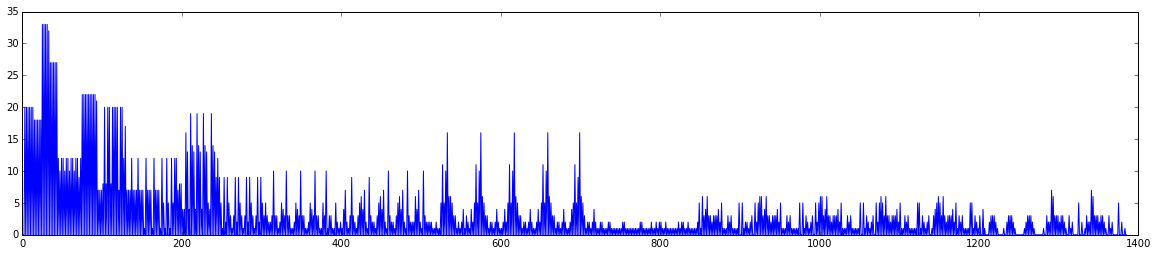

In [129]:
f, axs = plt.subplots(1,1)
f.set_size_inches((20,4))
axs.plot(np.diag(m))

732
522
852
1186
252

/xvdb/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


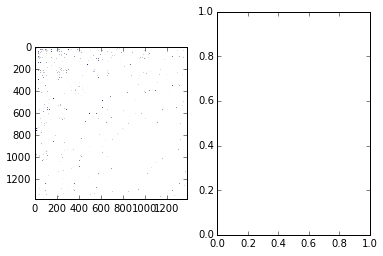

In [92]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1,2)
axs[0].imshow(np.log(m-np.diag(np.diag(m)))) #np.log(np.cov(X.T)))

In [61]:
import logging
import prepare_from_data_chain
import time
def read_X(config):
    n_data = {'basenp' : 300, 'chunking' : 100, 'segmentation' : 36, 'japanesene' : 100}[config['task']]
    n_data_train = {'basenp' : 150, 'chunking' : 50, 'segmentation' : 20, 'japanesene' : 50}[config['task']]
    data_indices = np.loadtxt(pygpstruct_location + '/data/datasplit.n_data=%s.txt' % n_data, dtype=np.int16) - 1 # need -1 because doing +1 inside prepare_data_chain
    
    # construct completed_arguments_dict for function
    # take most arguments from config
    common_arguments = {
        'data_indices_train' : data_indices[config['fold'],:n_data_train],
        'data_indices_test' : data_indices[config['fold'],n_data_train:],
        'data_folder' : pygpstruct_location + '/data/' + config['task'],
        'native_implementation': False,
    }
    config.update(common_arguments)
    if not 'console_log' in config:
        config['console_log'] = False
        
    logger = logging.getLogger('pyGPstruct') # reuse logger if existing
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    logger.handlers = [] # remove any existing handlers
    # create formatter
    formatter = logging.Formatter('%(asctime)sZ - %(levelname)s - %(message)s')
    formatter.converter=time.gmtime # will use GMT timezone for output, hence the Z
    # console log handler
    if (config['console_log'] ):
        ch = logging.StreamHandler(stream=sys.stdout)
        #ch.setLevel(logging.DEBUG) # seems not needed by default 
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    (ll_train, 
     posterior_marginals_test, 
     compute_error_nlm, 
     ll_test, 
     average_marginals, 
     write_marginals,
     read_marginals,
     n_labels, 
     X_train, 
     X_test) = prepare_from_data_chain.prepare_from_data_chain(
                                data_indices_train=config['data_indices_train'], 
                                data_indices_test=config['data_indices_test'],
                                data_folder=config['data_folder'],
                                logger=logger,
                                n_labels=2,
                                n_features_x=1386,
                                native_implementation=config['native_implementation'],
                                )
    return (X_train, X_test)

(X_train, X_test) = read_X({
        'console_log' : True,
        'task' : 'segmentation',
        'fold' : 0,
    })

2015-08-12 16:36:03,277Z - INFO - prepare_from_data_chain started with arguments: {'n_features_x': 1386, 'native_implementation': False, 'data_indices_test': array([32, 28, 34,  3, 22, 31,  1, 19, 20,  6,  4, 27, 10, 15,  0,  2], dtype=int16), 'data_indices_train': array([ 8, 18, 21, 12, 23, 35, 13, 17, 24, 33,  9, 30, 26, 11,  5,  7, 25,
       16, 14, 29], dtype=int16), 'n_labels': 2, 'logger': <logging.Logger object at 0x7ff5883499b0>, 'data_folder': '/xvdb/pygpstruct/data/segmentation'}
2015-08-12 16:36:03,401Z - DEBUG - loaded data from disk


In [86]:
X_train = X_train.astype(np.float32)

In [87]:
np.dot(X_train, X_train.T.conj())

<959x959 sparse matrix of type '<class 'numpy.float32'>'
	with 31944 stored elements in Compressed Sparse Row format>

In [64]:
np.cov(X_train.T)

/xvdb/anaconda3/lib/python3.4/site-packages/numpy/lib/function_base.py:1890: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


ValueError: dimension mismatch

In [ ]:
#eyeball resized images to see if they make sense
import glob
import matplotlib.pyplot as plt

n_plots = 5
f, axs = plt.subplots(1,n_plots)
f.set_size_inches((15,45))
label_files = glob.glob('/bigscratch/sb358/grid-exact/data/dags.classes_3.size_10/*.labels.npy')[:n_plots]
for i, label_file in enumerate(label_files):
    labels = np.load(label_file)
    axs[i].imshow(labels)


In [134]:
import sklearn.metrics.pairwise
p = sklearn.metrics.pairwise.euclidean_distances(X_train, X_train, squared=True)
np.median(p)

7.0

### 2015-07 timer for ARD kernel computation optimization 

This section contains the work I did to get a fast ARD kernel computation, which in addition would work on sparse feature vectors. 

What to do with this stuff? tempted to delete it all!

In [20]:
%load_ext line_profiler

In [94]:
import numpy as np
n_data_train=100
n_data_test=100
n_features=1000
lhp = {'variances' : np.log(np.random.rand(n_features)), 'jitter' : np.log(1e-4)}

import scipy.sparse
x_train=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_train, n_features)))
x_test=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_test, n_features)))

import numpy.testing
import kernels
#del kernels.kernel_exponential_ard.row_test_cache
kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
#%lprun -f kernels.kernel_exponential_ard  \
a = kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
#b = kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)
#np.testing.assert_array_almost_equal(a,b)

%timeit kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
#%timeit kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)

10 loops, best of 3: 125 ms per loop


In [121]:
n_data_train=100
n_data_test=100
n_features=100
lhp = {'variances' : np.log(np.random.rand(n_features)), 'jitter' : np.log(1e-4)}

import scipy.sparse
x_train=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_train, n_features)))
x_test=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_test, n_features)))

import numpy.testing
import kernels
#%lprun -f kernel_exponential_ard 
a = kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
b = kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)
np.testing.assert_array_almost_equal(a,b)

%timeit kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
#%timeit kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)

{}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache object at 0x7fbc8e5b8b38>}
{'100100': <kernels.kernel_exponential_ard.<locals>.cache obje

In [93]:
n_data_train=100
n_data_test=100
n_features=1000
lhp = {'variances' : np.log(np.random.rand(n_features)), 'jitter' : np.log(1e-4)}

import scipy.sparse
x_train=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_train, n_features)))
x_test=scipy.sparse.coo_matrix(np.random.binomial(n=1, p=0.05, size=(n_data_test, n_features)))

import numpy.testing
import kernels
#%lprun -f kernel_exponential_ard 
a = kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
b = kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)
np.testing.assert_array_almost_equal(a,b)

%timeit kernels.kernel_exponential_ard(x_train, x_test, lhp, no_jitter=True)
%timeit kernels.kernel_exponential_ard(x_train.toarray(), x_test.toarray(), lhp, no_jitter=True)

cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
cached
10 loops, best of 3: 153 ms per loop
1 loops, best of 3: 11 s per loop


In [10]:
import logging
import prepare_from_data_chain
import time
def kernel_experiment_from_config(config):
    n_data = {'basenp' : 300, 'chunking' : 100, 'segmentation' : 36, 'japanesene' : 100}[config['task']]
    n_data_train = {'basenp' : 150, 'chunking' : 50, 'segmentation' : 20, 'japanesene' : 50}[config['task']]
    data_indices = np.loadtxt(pygpstruct_location + '/data/datasplit.n_data=%s.txt' % n_data, dtype=np.int16) - 1 # need -1 because doing +1 inside prepare_data_chain
    
    # construct completed_arguments_dict for function
    # take most arguments from config
    common_arguments = {
        'data_indices_train' : data_indices[config['fold'],:n_data_train],
        'data_indices_test' : data_indices[config['fold'],n_data_train:],
        'data_folder' : pygpstruct_location + '/data/' + config['task'],
        'native_implementation': False,
    }
    config.update(common_arguments)
    if not 'console_log' in config:
        config['console_log'] = False
        
    logger = logging.getLogger('pyGPstruct') # reuse logger if existing
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    logger.handlers = [] # remove any existing handlers
    # create formatter
    formatter = logging.Formatter('%(asctime)sZ - %(levelname)s - %(message)s')
    formatter.converter=time.gmtime # will use GMT timezone for output, hence the Z
    # console log handler
    if (config['console_log'] ):
        ch = logging.StreamHandler(stream=sys.stdout)
        #ch.setLevel(logging.DEBUG) # seems not needed by default 
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    (ll_train, 
     posterior_marginals_test, 
     compute_error_nlm, 
     ll_test, 
     average_marginals, 
     write_marginals,
     read_marginals,
     n_labels, 
     X_train, 
     X_test) = prepare_from_data_chain.prepare_from_data_chain(
                                data_indices_train=config['data_indices_train'], 
                                data_indices_test=config['data_indices_test'],
                                data_folder=config['data_folder'],
                                logger=logger,
                                n_labels=2,
                                n_features_x=1386,
                                native_implementation=config['native_implementation'],
                                )
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    logger.debug('computing kernel for X_train of type %s' % str(type(X_train)))
    config['kernel'](X_train, X_test, config['lhp_init'], no_jitter=True, logger=logger)


In [ ]:
import copy
import kernels

def set_lhp_target_ard(lhp_, lhp_target):
    """smartly sets dict values from array"""
    new_lhp = copy.deepcopy(lhp_)
    new_lhp["variances"] = lhp_target
    return new_lhp
def get_lhp_target_ard(lhp_):
    """creates array from dict"""
    return lhp_["variances"]

kernel_experiment_from_config({
        'console_log' : True,
        'task' : 'segmentation',
        'fold' : 0,
        'hp_sampling_thinning': 1,
        'hp_sampling_mode': 'slice sample theta',
        'kernel' : kernel_exponential_ard,
        'lhp_gset' : (get_lhp_target_ard, set_lhp_target_ard),
        'lhp_init' : {'unary': np.log(1), 'binary': np.log(1), 'jitter': np.log(1e-4),
                     'variances' : np.log(np.ones((1386)))}
    })